In [1]:
suppressPackageStartupMessages(library(DESeq2))

In [2]:
dds <- makeExampleDESeqDataSet(n=100,m=18)
dds$genotype <- factor(rep(rep(c("I","II","III"),each=3),2))
design(dds) <- ~ genotype + condition + genotype:condition
dds <- DESeq(dds)
resultsNames(dds)


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Intercept"              "genotype_II_vs_I"       "genotype_III_vs_I"     
[4] "condition_B_vs_A"       "genotypeII.conditionB"  "genotypeIII.conditionB"

In [24]:
# the condition effect for genotype I (the main effect)
res <- results(dds, contrast=list( c( "genotypeII.conditionB", 'condition_B_vs_A') ))
res <- res[order(res$padj),]
summary(res)
head(res)



out of 100 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): genotypeII.conditionB+condition_B_vs_A effect 
Wald test p-value: genotypeII.conditionB+condition_B_vs_A effect 
DataFrame with 6 rows and 6 columns
               baseMean     log2FoldChange             lfcSE              stat
              <numeric>          <numeric>         <numeric>         <numeric>
gene41 86.9318128037947 -0.996318088922235  0.36270367475593 -2.74692030510216
gene48 6.46433509881799  -3.22110623739051  1.34284228317468 -2.39872267782284
gene58  5.6238145016231   3.08679701066122  1.23252717315591  2.50444540119746
gene96  19.131843887719   1.49258416313921 0.627831670212522  2.37736360549312
gene14 7.50053710838745   2.19355169997956  1.09535022375008  2.00260305098551
gene65  9.3367702709541   2.32104774345524  1.14437554058829  2.02822208368947
                    pvalue              padj
                 <numeric>         <numeric>
gene41 0.00601577503030651 0.435922258175564
gene48  0.0164523696744759 0.435922258175564
gene58  0.01226

In [15]:
suppressPackageStartupMessages(library(ggplot2))

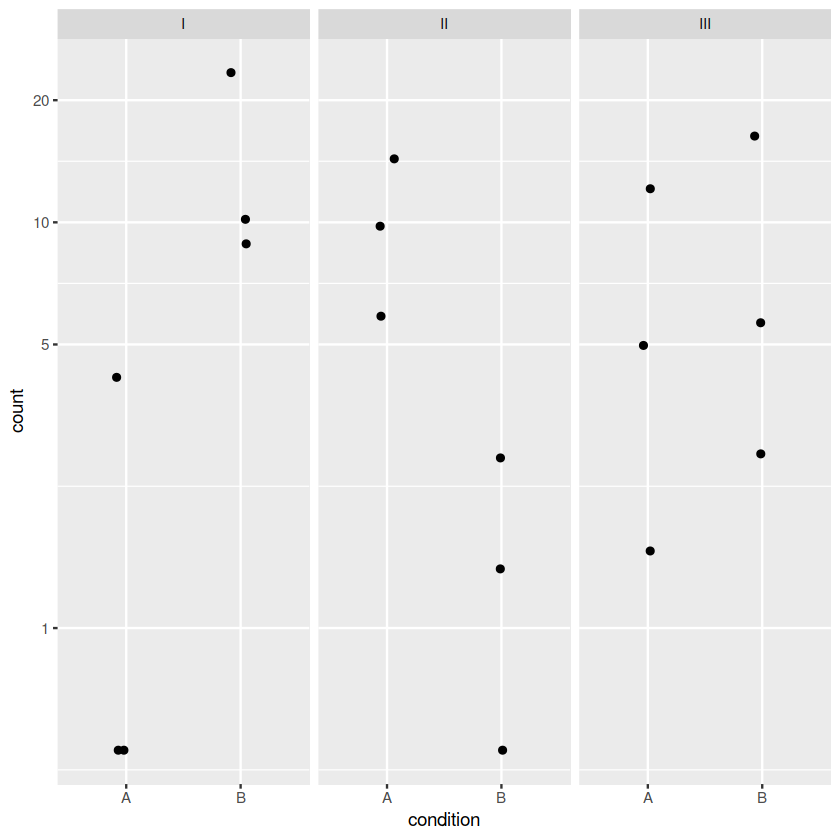

In [23]:
d <- plotCounts(dds, gene=c("gene48"), intgroup=c("condition", "genotype"), returnData=TRUE)
ggplot(d, aes(x=condition, y=count)) + 
    geom_point(position=position_jitter(w=0.1,h=0)) + 
    scale_y_log10(breaks=c(1,5,10, 20)) + 
    facet_wrap(~genotype)


In [2]:
%%bash
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/counts

In [6]:
import pandas as pd
import re
import os
data_dir = '/data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/genewiz_rnaseq-pe-unstranded-with-sjdb'
comp_files = [
    [
        'mm10Liver.rnaseq.non-targeting.rep1.star2.featurecounts.counts.txt',
        'mm10Liver.rnaseq.non-targeting.rep2.star2.featurecounts.counts.txt',
        'mm10Liver.rnaseq.non-targeting.rep3.star2.featurecounts.counts.txt',
        'mm10Liver.rnaseq.non-targeting.rep4.star2.featurecounts.counts.txt',
        'mm10Liver.rnaseq.PBS.rep1.star2.featurecounts.counts.txt',
        'mm10Liver.rnaseq.PBS.rep2.star2.featurecounts.counts.txt',
        'mm10Liver.rnaseq.PBS.rep3.star2.featurecounts.counts.txt',
        'mm10Liver.rnaseq.PBS.rep4.star2.featurecounts.counts.txt',
        'mm10Liver.rnaseq.PDX1.rep1.star2.featurecounts.counts.txt',
        'mm10Liver.rnaseq.PDX1.rep2.star2.featurecounts.counts.txt',
        'mm10Liver.rnaseq.PDX1.rep3.star2.featurecounts.counts.txt',
        'mm10Liver.rnaseq.PDX1.rep4.star2.featurecounts.counts.txt'
    ]
]

def clean_count_column(s):
    return ".".join(s.split('/')[-1].split('.')[:4])


for comp_i0, files in enumerate(comp_files):
    df = None
    comp_i1 = comp_i0 + 1

    for f in files:
        df_tmp = pd.read_csv(os.path.join(data_dir, f), sep='\t', skiprows=1, index_col=0)
        df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
        if df is None:
            df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].round().astype(dtype='int')

    df.columns = [c.replace("-", "_") for c in df.columns]
    df.to_csv('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/counts/mm10Liver.all.counts.txt',
             sep='\t')

    

In [7]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    --array=1-2 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs/rnaseq_deseq2.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    mm10Liver.rnaseq.PDX1@mm10Liver.rnaseq.non_targeting \
    mm10Liver.rnaseq.PDX1@mm10Liver.rnaseq.PBS \
    mm10Liver.rnaseq.PBS@mm10Liver.rnaseq.non_targeting \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"@" -f1)
CONTROL=$(echo $COMPARISON | cut -d"@" -f2)
Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --treatments $(echo ${TREAT}.rep{1,2,3,4}) \
    --controls $(echo ${CONTROL}.rep{1,2,3,4}) \
    --lfcShrink apeglm \
    --counts-skip-ncols 3 \
    --no-model-reps \
    --outdir /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/ \
    --counts /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/counts/mm10Liver.all.counts.txt
EOF

Submitted batch job 15346034


Siklenka_6563_201007A5

In [1]:
import pandas as pd
import re
import os
data_dir = '/data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/Siklenka_6563_201007A5-pe-revstranded-with-sjdb'
comp_files = [
    [
        'KS150.CreNeg.g5.rep2.star2.featurecounts.counts.txt',
        'KS150.CreNeg.g5.rep3.star2.featurecounts.counts.txt',
        'KS150.CreNeg.NTC.rep1.star2.featurecounts.counts.txt',
        'KS150.CreNeg.NTC.rep2.star2.featurecounts.counts.txt',
        'KS150.CrePos.g5.rep1.star2.featurecounts.counts.txt',
        'KS150.CrePos.g5.rep2.star2.featurecounts.counts.txt',
        'KS150.CrePos.g5.rep3.star2.featurecounts.counts.txt',
        'KS150.CrePos.NTC.rep1.star2.featurecounts.counts.txt',
        'KS150.CrePos.NTC.rep2.star2.featurecounts.counts.txt',
        'KS150.CrePos.NTC.rep3.star2.featurecounts.counts.txt'
    ]
]

def clean_count_column(s):
    return ".".join(s.split('/')[-1].split('.')[:4])


for comp_i0, files in enumerate(comp_files):
    df = None
    comp_i1 = comp_i0 + 1

    for f in files:
        df_tmp = pd.read_csv(os.path.join(data_dir, f), sep='\t', skiprows=1, index_col=0)
        df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
        if df is None:
            df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].round().astype(dtype='int')

    df.columns = [c.replace("-", "_") for c in df.columns]
    df.to_csv('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/counts/cre.pos_neg.counts.txt',
             sep='\t')

    

In [4]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    --array=0-3 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs/cre_pos_neg.rnaseq_deseq2.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    KS150.CreNeg.g5@KS150.CreNeg.NTC \
    KS150.CrePos.g5@KS150.CrePos.NTC \
    KS150.CrePos.g5@KS150.CreNeg.g5 \
    KS150.CrePos.NTC@KS150.CreNeg.NTC \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"@" -f1)
CONTROL=$(echo $COMPARISON | cut -d"@" -f2)
Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --treatments $(echo ${TREAT}.rep{1,2,3}) \
    --controls $(echo ${CONTROL}.rep{1,2,3}) \
    --lfcShrink apeglm \
    --counts-skip-ncols 3 \
    --no-model-reps \
    --outdir /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/ \
    --counts /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/counts/cre.pos_neg.counts.txt
EOF

Submitted batch job 23101527


In [1]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
cd /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/
for ii in $(/bin/ls -1 KS150*.txt | /bin/grep -v rlog | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

Siklenka_6563_201007A5 with MiSeq re-do of KS150.CreNeg.g5.rep3 (low counts) and KS150.CreNeg.g5.rep1 (dropped)

In [3]:
import pandas as pd
import re
import os

def clean_count_column(s):
    return ".".join(s.split('/')[-1].split('.')[:4])

# data_dir = '/data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/p300RNAseq_miseq-pe-revstranded-with-sjdb'
data_dir = '/data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/Heaton_6594_201110A5-pe-revstranded-with-sjdb'
comp_files = [
        'KS150.CreNeg.g5.rep1.star2.featurecounts.counts.txt',
        'KS150.CreNeg.g5.rep3.star2.featurecounts.counts.txt',
]


df = None

for f in comp_files:
    df_tmp = pd.read_csv(os.path.join(data_dir, f), sep='\t', skiprows=1, index_col=0)
    df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
    if df is None:
        df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
    else:
        df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')


data_dir = '/data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/Siklenka_6563_201007A5-pe-revstranded-with-sjdb'
comp_files = [
        'KS150.CreNeg.g5.rep2.star2.featurecounts.counts.txt',
#         'KS150.CreNeg.g5.rep3.star2.featurecounts.counts.txt',
        'KS150.CreNeg.NTC.rep1.star2.featurecounts.counts.txt',
        'KS150.CreNeg.NTC.rep2.star2.featurecounts.counts.txt',
        'KS150.CrePos.g5.rep1.star2.featurecounts.counts.txt',
        'KS150.CrePos.g5.rep2.star2.featurecounts.counts.txt',
        'KS150.CrePos.g5.rep3.star2.featurecounts.counts.txt',
        'KS150.CrePos.NTC.rep1.star2.featurecounts.counts.txt',
        'KS150.CrePos.NTC.rep2.star2.featurecounts.counts.txt',
        'KS150.CrePos.NTC.rep3.star2.featurecounts.counts.txt'
]

for f in comp_files:
    df_tmp = pd.read_csv(os.path.join(data_dir, f), sep='\t', skiprows=1, index_col=0)
    df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
    if df is None:
        df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
    else:
        df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

count_columns = ["rep" in c for c in df.columns]
df.loc[:, count_columns] = df.loc[:, count_columns].round().astype(dtype='int')

df.columns = [c.replace("-", "_") for c in df.columns]
# df.to_csv('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/counts/cre.pos_neg.counts.redo_miseq.txt',
df.to_csv('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/counts/cre.pos_neg.counts.redo_nextseq.txt',
         sep='\t')

    

In [5]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    --array=0-1 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs/cre_pos_neg.rnaseq_deseq2.redo_miseq.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    KS150.CreNeg.g5@KS150.CreNeg.NTC \
    KS150.CrePos.g5@KS150.CreNeg.g5 \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"@" -f1)
CONTROL=$(echo $COMPARISON | cut -d"@" -f2)
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/miseq && \
Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --treatments $(echo ${TREAT}.rep{1,2,3}) \
    --controls $(echo ${CONTROL}.rep{1,2,3}) \
    --lfcShrink apeglm \
    --counts-skip-ncols 3 \
    --no-model-reps \
    --outdir /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/miseq \
    --counts /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/counts/cre.pos_neg.counts.redo_miseq.txt
EOF

Submitted batch job 23231379


In [4]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    --array=0-1 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs/cre_pos_neg.rnaseq_deseq2.redo_nextseq.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    KS150.CreNeg.g5@KS150.CreNeg.NTC \
    KS150.CrePos.g5@KS150.CreNeg.g5 \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"@" -f1)
CONTROL=$(echo $COMPARISON | cut -d"@" -f2)
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/nextseq && \
Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --treatments $(echo ${TREAT}.rep{1,2,3}) \
    --controls $(echo ${CONTROL}.rep{1,2,3}) \
    --lfcShrink apeglm \
    --counts-skip-ncols 3 \
    --no-model-reps \
    --outdir /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/nextseq \
    --counts /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/counts/cre.pos_neg.counts.redo_nextseq.txt
EOF

Submitted batch job 23553205


In [ ]:
# %load /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R
#!/usr/bin/env Rscript
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(matrixStats))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library("argparse"))

# Rewrite DESeq2 plotPCA function to specify which PC to plot
plotPCA_ = function(object, intgroup="condition", ntop=500, returnData=FALSE, pcX=1, pcY=2, ignoreReps=FALSE)
{
  # calculate the variance for each gene
  rv <- rowVars(assay(object))

  # select the ntop genes by variance
  select <- order(rv, decreasing=TRUE)[seq_len(min(ntop, length(rv)))]

  # perform a PCA on the data in assay(x) for the selected genes
  pca <- prcomp(t(assay(object)[select,]))

  # the contribution to the total variance for each component
  percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

  if (!all(intgroup %in% names(colData(object)))) {
    stop("the argument 'intgroup' should specify columns of colData(dds)")
  }

  intgroup.df <- as.data.frame(colData(object)[, intgroup, drop=FALSE])  
  # add the intgroup factors together to create a new grouping factor
  group <- if (length(intgroup) > 1) {
    factor(apply( intgroup.df, 1, paste, collapse=":"))
  } else {
    colData(object)[[intgroup]]
  }
    
  if (returnData) {
    attr(d, "percentVar") <- c(percentVar[pcX], percentVar[pcY])
    return(d)
  }
  rep <- colData(object)[['rep']]
#   rep <- row.names(colData(dds))
  if (!ignoreReps){
      # Add replicate info
#       rep <- colData(object)[['rep']]

        # assembly the data for the plot
      d <- data.frame(PCX=pca$x[,pcX], PCY=pca$x[,pcY], group=group, rep=rep, intgroup.df, name=colnames(object))

      ggplot(data=d, aes_string(x="PCX", y="PCY", color="group", shape="rep")) + geom_point(size=3) + 
        xlab(paste0("PC", pcX, ": ",round(percentVar[pcX] * 100),"% variance")) +
          ylab(paste0("PC", pcY, ": ",round(percentVar[pcY] * 100),"% variance")) +
      scale_shape_manual(values=seq(0,15))
  } else {
#       batch <- as.factor(colData(object)[['batch']])
        # assembly the data for the plot
      d <- data.frame(PCX=pca$x[,pcX], PCY=pca$x[,pcY], group=group, intgroup.df, name=colnames(object))

      ggplot(data=d, aes_string(x="PCX", y="PCY", color="group")) + 
          geom_point(size=3) +
          geom_text(aes(label=rep),hjust=0, vjust=0) +
          xlab(paste0("PC", pcX, ": ",round(percentVar[pcX] * 100),"% variance")) +
          ylab(paste0("PC", pcY, ": ",round(percentVar[pcY] * 100),"% variance")) +
      scale_shape_manual(values=seq(0,15))
  }
#     + coord_fixed()
}

# create parser object
parser <- ArgumentParser()

# specify our desired options 
# by default ArgumentParser will add an help option 
parser$add_argument("-c", "--controls", nargs="+", help="Featurecounts file for controls")
parser$add_argument("-t", "--treatments", nargs="+", help="Featurecounts file for treatments")
parser$add_argument("--counts", nargs="+", help="Count matrix (or matrices). Count columns should match controls and treatments specified")
parser$add_argument("--outdir", help="Output directory where result files will be saved.")
parser$add_argument("--lfcShrink", required=F, 
                    help="Perform effect size shrinkage (types: normal, apeglm and ashr. See Zhu, Ibrahim, and Love 2018).")
parser$add_argument("--lib-sizes", required=F, 
                    help="Use library sizes as scaling factor overwritting the default total counts per library")
parser$add_argument("--counts-skip-ncols", required=F, 
                    help="Skip n first columns from count matrix")
parser$add_argument("--counts-only-treatments-and-controls", required=F, action="store_true", default=FALSE,
                    help="Keep only the counts from the treatment and control samples (affects dispersion estimates, but can speed up things significantly)")
parser$add_argument("--no-filter", required=F, action="store_true", default=FALSE,
                    help="By default, lowly expressed regions in only 1 sample are removed. Specify if no filter should be done")
parser$add_argument("--no-model-reps", required=F, action="store_true", default=FALSE,
                    help="Ignore replicates when plotting PCA components")
parser$add_argument("--norm-by-ercc", required=F, action="store_true", default=FALSE,
                    help="Normalized using ERCC counts (probes staring by ERCC-)")
parser$add_argument("--samples-info-df", required=F,
                    help="Optionally, provide a DataFrame with sample info (which in DESeq2 is used as column data)")
parser$add_argument("--design-formula", required=F,
                    help="Optionally, if provided, use this design formular instead of trying to infer it from data")
parser$add_argument("--control-substr", required=F, default=FALSE,
                    help="Optionally, provide a substr found in rownames to identify control counts (e.g. housekeeping genes, spike-ins, etc.). It changes the estimateSizeFactors function")
parser$add_argument("--pca-int-groups", required=F, nargs='*',
                    help="Optionally, columns from design formula to be used in PCA analysis")

# get command line options, if help option encountered print help and exit,
# otherwise if options not found on command line then set defaults, 
args <- parser$parse_args()
args
treatments <- args$treatments
controls <- args$controls
outdir <- args$outdir

ff <- args$counts
dd <- lapply(ff, read.csv, header=TRUE, sep="\t", stringsAsFactors=FALSE, row.names=1)
xx <- do.call(cbind, dd)

countData <- xx
if (!is.null(args$counts_skip_ncols)){
    countData <- xx[, -c(1:args$counts_skip_ncols)]
}

colnames(countData)[colnames(countData)%in%append(treatments, controls)]
if (args$counts_only_treatments_and_controls){
#     countData <- xx %>% select(unlist(append(treatments, controls)))
    countData <- subset(xx, select = colnames(countData)[colnames(countData)%in%append(treatments, controls)])
}

controls
treatments
samples_no_reps <- gsub("(.*)\\..*", "\\1", colnames(countData))
reps <- gsub(".*\\.(.*)", "\\1", colnames(countData))
conditions <- samples_no_reps
conditions

# Reorder condition comparisons to always compute log2 fold changes of treat vs control
conditions_pair <- unique(conditions)
control_conditions <- unique(gsub("(.*)\\..*", "\\1", controls))
treatment_conditions <- unique(gsub("(.*)\\..*", "\\1", treatments))

if (!is.null(args$samples_info_df)){
    colData <- read.csv(args$samples_info_df, 
                        header=TRUE, sep="\t", 
                        stringsAsFactors=TRUE, row.names=1)
    colData <- colData[colnames(countData), ]
    design_formula_str <- paste(c("~ ", paste(colnames(colData), collapse = " + ")), collapse='')
    if (!is.null(args$design_formula)){
        design_formula_str <- args$design_formula
    }
    print(design_formula_str)
    dds <- DESeqDataSetFromMatrix(countData = countData,
                                  colData = colData,
                                  design = formula(design_formula_str))
    intgroup <- colnames(colData)  # For PCA plots
} else {
    intgroup <- c("condition")  # For PCA plots
    colData <- data.frame(condition=conditions, rep=reps, row.names=colnames(countData))    
    if (!(args$no_model_reps)){
        print(reps)
    #     colData <- data.frame(condition=conditions, rep=reps, row.names=colnames(countData))
        dds <- DESeqDataSetFromMatrix(countData = countData,
                                      colData = colData,
                                      design = ~ rep + condition)
    } else {
    #     colData <- data.frame(condition=conditions, row.names=colnames(countData))
        dds <- DESeqDataSetFromMatrix(countData = countData,
                                      colData = colData,
                                      design = ~ condition)
    }
    # Relevel to setup control as reference
    dds$condition <- relevel(dds$condition, ref = control_conditions)
} 


# Optionally: if lib_sizes provided, manually assigned scale factors
if (!is.null(args$lib_sizes)){
    lib_sizes <- read.table(args$lib_sizes, sep="\t", row.names=1)
    lib_sizes <- lib_sizes[colnames(countData), ]
    lib_sizes_scale_factors <- lib_sizes/min(lib_sizes)
    sizeFactors(dds) <- lib_sizes_scale_factors    
}

if (args$norm_by_ercc){
    ercc_genes <- countData[grepl("^ERCC", rownames(countData)), ]
    dds <- DESeqDataSetFromMatrix(countData = countData[!grepl("^ERCC", rownames(countData)), ],
                              colData = colData,
                              design = ~ condition)
    ercc_dds <- DESeqDataSetFromMatrix(countData = ercc_genes, 
                                       colData = colData,
                                       design = ~ condition)
    sizeFactors(dds) <-  sizeFactors(estimateSizeFactors(ercc_dds))
    # Relevel to setup control as reference
    dds$condition <- relevel(dds$condition, ref = control_conditions)
}

# Pre-filtering low count genes
# dds <- dds[ rowSums(counts(dds)) > 5, ]
if (!args$no_filter){
    dds <- dds[ rowSums(fpm(dds, robust = FALSE)>=2) > 1, ]
}

# Run DESeq2
# dds <- DESeq(dds, betaPrior=FALSE)
if (is.character(args$control_substr)){
    control_idxs <- which(grepl(args$control_substr, rownames(countData)))
    dds <- estimateSizeFactors(dds, controlGenes=control_idxs)
} else {
    dds <- estimateSizeFactors(dds)
}
dds <- estimateDispersions(dds)
dds <- nbinomWaldTest(dds)


# Calculate comparison string name 
treat_vs_contr <- paste0(treatment_conditions, '_vs_', control_conditions)

# Extracting transformed values for PCA analysis
vsd <- tryCatch({
    vst(dds, blind=FALSE)
}, error = function(e){
    varianceStabilizingTransformation(dds, blind=FALSE)
})


# Create PCA plot for the first and second PCs
pdf(paste0(outdir, '/', treat_vs_contr, '.pca.1_vs_2.pdf'), width=10, height=8)
plotPCA_(vsd, intgroup=intgroup, ntop=500, pcX=1, pcY=2, ignoreReps=args$no_model_reps)
dev.off()
# Create PCA plot for the second and third PCs
pdf(paste0(outdir, '/', treat_vs_contr, '.pca.2_vs_3.pdf'), width=10, height=8)
plotPCA_(vsd, intgroup=intgroup, ntop=500, pcX=2, pcY=3, ignoreReps=args$no_model_reps)
dev.off()
# Create PCA plot for the third and fourth PCs
pdf(paste0(outdir, '/', treat_vs_contr, '.pca.3_vs_4.pdf'), width=10, height=8)
plotPCA_(vsd, intgroup=intgroup, ntop=500, pcX=3, pcY=4, ignoreReps=args$no_model_reps)
dev.off()

c('condition',  
  conditions_pair[conditions_pair %in% treatment_conditions], 
  conditions_pair[conditions_pair %in% control_conditions])
res <- results(dds, 
               contrast=c('condition', 
                          conditions_pair[conditions_pair %in% treatment_conditions],
                          conditions_pair[conditions_pair %in% control_conditions]), 
               alpha=0.05, 
               independentFiltering=F)  # TODO: Test how the results look without independent filtering

# Print out result names
resultsNames(dds)

# Shrink log2 fold-change values?
if (!is.null(args$lfcShrink)){
    # If lfcShrinkage specified, save unshrunk values
    resOrdered <- res[order(res$padj),]

    # Save sorted results in a text file
    write.table(resOrdered, 
                file=paste0(outdir, '/', treat_vs_contr, '.unshrunk.txt'),
                quote = FALSE, row.names=TRUE, sep = '\t')

    # Create plot for the log2 fold changes from the treatment over the mean of normalized counts
    pdf(paste0(outdir, '/', treat_vs_contr, '.unshrunk.pdf'))
    log2fc_lim <- ceiling(max(max(res$log2FoldChange), abs(min(res$log2FoldChange))))
    plotMA(res, main=paste0("DESeq2_unshrunk_lfc_", treat_vs_contr), ylim=c(-log2fc_lim,log2fc_lim))
    dev.off()

    # Calculate lfcShrink values
    targ_contrast <- paste0("condition_", treat_vs_contr)
    res <- lfcShrink(dds, 
                     coef=targ_contrast, 
                     type=args$lfcShrink)
}

# Sort by adjusted p-value (FDR)
(resOrdered <- res[order(res$padj),])

# Print out summary of results
summary(resOrdered, alpha=0.05)

# Try IHW multiple hypothesis testing package
library("IHW")
resIHW <- results(dds, 
                  alpha=0.05,
                  contrast=c('condition', 
                          conditions_pair[conditions_pair %in% treatment_conditions],
                          conditions_pair[conditions_pair %in% control_conditions]),
                  filterFun=ihw
                 )
summary(resIHW, alpha=0.05)
resIHW <- resIHW[order(resIHW$padj),]

# Create plot for the log2 fold changes from the treatment over the mean of normalized counts
log2fc_lim <- ceiling(max(max(res$log2FoldChange), abs(min(res$log2FoldChange))))
pdf(paste0(outdir, '/', treat_vs_contr, '.pdf'))
plotMA(res, main=paste0("DESeq2_", treat_vs_contr), ylim=c(-log2fc_lim,log2fc_lim))
dev.off()

# Create plot for dispersion of normalized counts
pdf(paste0(outdir, '/', treat_vs_contr, '.mean_counts_dispersion.pdf'))
plotDispEsts(dds)
dev.off()

# To check if there are too many outliers, plot the Cook distances 
pdf(paste0(outdir, '/', treat_vs_contr, '.cook_distances.pdf'))
par(mar=c(8,5,2,2))
boxplot(log10(assays(dds)[["cooks"]]), range=0, las=2)
dev.off()

# Save sorted results in a text file
write.table(resOrdered, 
            file=paste0(outdir, '/', treat_vs_contr, '.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')

# Save IHW results in a text file
write.table(resIHW, 
            file=paste0(outdir, '/', treat_vs_contr, '.IHW.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')

# Save vsd transformed values
write.table(assay(vsd), 
            file=paste0(outdir, '/', treat_vs_contr, '.vsd.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')


rld <- rlog(dds) # rlog transformed values (typically used for clustering - see DESeq2 manual for details)
# Save rlog transformed values
write.table(assay(rld), 
            file=paste0(outdir, '/', treat_vs_contr, '.rlog.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')

# Save .RData object
save.image(paste0(outdir, '/', treat_vs_contr, '.RData'))

cat("Done!")


In [ ]:
res <- results(dds, contrast=c("guide", "g5", "NTC"), alpha=0.05, independentFiltering=F)
res <- res[order(res$padj),]

In [ ]:
dds <- DESeqDataSetFromMatrix(countData = countData,  colData = colData, design = ~ guide + cre + guide:cre)
dds$guide <- relevel(dds$guide, ref = "NTC")
dds <- dds[ rowSums(fpm(dds, robust = FALSE)>=2) > 1, ]
dds <- estimateSizeFactors(dds)
dds <- estimateDispersions(dds)
dds <- nbinomWaldTest(dds)
resultsNames(dds)

res_aux <- results(dds, contrast=list(c("guideg5.crePos")))
res_aux <- res_aux[order(res_aux$padj),]
summary(res_aux)

res_aux <- results(dds, contrast=c("cre", "Pos", "Neg"))
res_aux <- res_aux[order(res_aux$padj),]
summary(res_aux)

res_aux <- results(dds, contrast=list("cre_Pos_vs_Neg", "guideg5.crePos"))
res_aux <- res_aux[order(res_aux$padj),]
summary(res_aux)
head(res_aux)


In [ ]:
res_aux <- results(dds, contrast=list(c("guideg5.crePos")))
res_aux <- res_aux[order(res_aux$padj),]
summary(res_aux)
outfile <- '/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/miseq/guideg5.crePos.txt'
write.table(res_aux, outfile, sep = '\t',  quote = FALSE, row.names=TRUE)


In [ ]:
res_aux <- results(dds, contrast=list(c("cre_Pos_vs_Neg")))
res_aux <- res_aux[order(res_aux$padj),]
summary(res_aux)
outfile <- '/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/miseq/cre_Pos_vs_Neg.txt'
write.table(res_aux, outfile, sep = '\t',  quote = FALSE, row.names=TRUE)


In [ ]:

pdf('/data/reddylab/Alex/collab/20190701_Matt/foxp3.interaction_term.counts.pdf', width=6, height=4)
d <- plotCounts(dds, gene=c("ENSMUSG00000039521.12"), intgroup=c("cre", "guide"), returnData=TRUE)
ggplot(d, aes(x=cre, y=count)) + 
    geom_point(position=position_jitter(w=0.1,h=0)) + 
    scale_y_log10(breaks=c(25,100,400, 1000)) + 
    facet_wrap(~guide) +
    ggtitle("Foxp3 counts")
dev.off()


In [ ]:

pdf('/data/reddylab/Alex/collab/20190701_Matt/trp53inp1.interaction_term.counts.pdf', width=6, height=4)
d <- plotCounts(dds, gene=c("ENSMUSG00000028211.11"), intgroup=c("cre", "guide"), returnData=TRUE)
ggplot(d, aes(x=cre, y=count)) + 
    geom_point(position=position_jitter(w=0.1,h=0)) + 
    scale_y_log10(breaks=c(25,100,400, 1000)) + 
    facet_wrap(~guide) +
    ggtitle("Trp53inp1 counts")
dev.off()


In [ ]:

pdf('/data/reddylab/Alex/collab/20190701_Matt/serpina3g.interaction_term.counts.pdf', width=6, height=4)
d <- plotCounts(dds, gene=c("ENSMUSG00000041481.16"), intgroup=c("cre", "guide"), returnData=TRUE)
ggplot(d, aes(x=cre, y=count)) + 
    geom_point(position=position_jitter(w=0.1,h=0)) + 
    scale_y_log10(breaks=c(25,100,400, 1000)) + 
    facet_wrap(~guide) +
    ggtitle("Serpina3g counts")
dev.off()


In [9]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
cd /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/miseq/
python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
    /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/miseq/cre_Pos_vs_Neg.txt \
    /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/miseq/cre_Pos_vs_Neg.with_genes.txt


In [6]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
cd /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/miseq/
for ii in $(/bin/ls -1 KS150*.txt | /bin/grep -v rlog | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

In [6]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
cd /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/nextseq/
for ii in $(/bin/ls -1 KS150*.txt | /bin/grep -v rlog | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

In [1]:
%matplotlib inline

('======', 'cre_Pos_vs_Neg', '======')


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000041481.16,388.749018,2.975399,0.294574,10.100687,5.485661e-24,6.645879e-20,Serpina3g,protein_coding
1,ENSMUSG00000020607.6,1054.704818,1.117137,0.111934,9.980346,1.858186e-23,1.125596e-19,Fam84a,protein_coding
2,ENSMUSG00000028211.11,2435.487906,-1.832315,0.190921,-9.597231,8.212087e-22,3.316314e-18,Trp53inp1,protein_coding
3,ENSMUSG00000035258.14,176.900551,2.725132,0.297130,9.171502,4.664727e-20,1.412829e-16,Abi3bp,protein_coding
4,ENSMUSG00000038295.14,2330.692501,-1.496995,0.165551,-9.042497,1.531330e-19,3.092011e-16,Atg9b,protein_coding
5,ENSMUSG00000033032.15,173.384368,2.097658,0.231564,9.058663,1.320588e-19,3.092011e-16,Afap1l1,protein_coding
6,ENSMUSG00000074796.10,1107.799525,-1.582544,0.180596,-8.762911,1.902715e-18,3.293056e-15,Slc4a11,protein_coding
7,ENSMUSG00000009418.15,304.577403,2.927918,0.338632,8.646312,5.319068e-18,8.055064e-15,Nav1,protein_coding
8,ENSMUSG00000094910.1,105.094270,3.666795,0.428918,8.548934,1.242309e-17,1.672286e-14,D430019H16Rik,protein_coding
9,ENSMUSG00000030671.9,3005.362658,-1.160221,0.136022,-8.529631,1.468158e-17,1.778673e-14,Pde3b,protein_coding


('======', 'cre_Pos_vs_Neg.guideg5.crePos', '======')


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000020607.6,1054.704818,1.442507,0.248238,5.810990,6.210463e-09,0.000075,Fam84a,protein_coding
1,ENSMUSG00000028860.13,654.576673,-1.311227,0.272465,-4.812464,1.490805e-06,0.009031,Sytl1,protein_coding
2,ENSMUSG00000002996.17,831.978030,-1.165954,0.254237,-4.586089,4.516267e-06,0.018238,Hbp1,protein_coding
3,ENSMUSG00000039521.12,166.380346,-3.737422,0.834112,-4.480720,7.439164e-06,0.022531,Foxp3,protein_coding
4,ENSMUSG00000038295.14,2330.692501,-1.545406,0.363537,-4.251028,2.127917e-05,0.042966,Atg9b,protein_coding
5,ENSMUSG00000092341.2,5038.926250,-1.341566,0.313545,-4.278705,1.879837e-05,0.042966,Malat1,lincRNA


('======', 'guideg5.crePos', '======')


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000039521.12,166.380346,3.953584,0.52453,7.537377,4.795181e-14,5.809361e-10,Foxp3,protein_coding


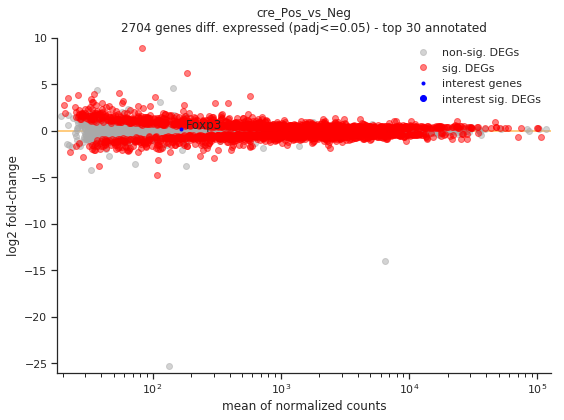

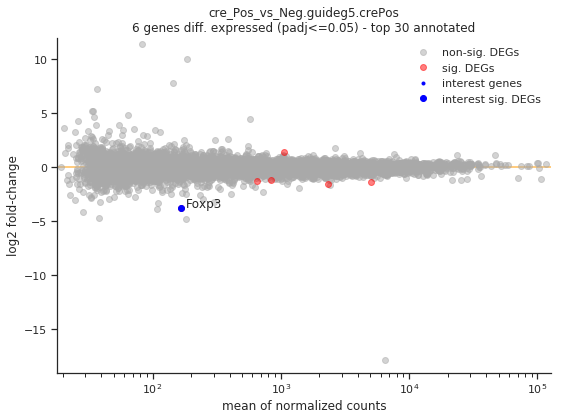

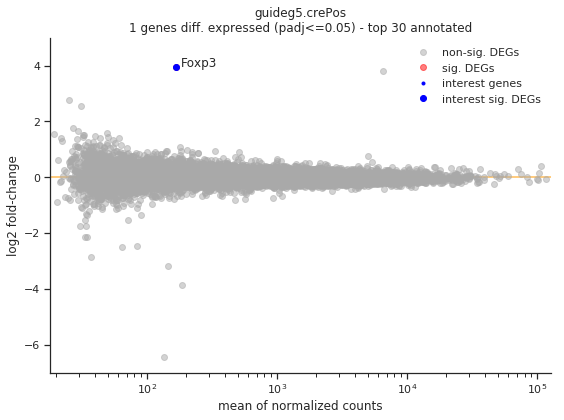

In [10]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.05
top_to_report = 30
log2fc_thres = np.log2(2)
special_genes = ["Foxp3"]
comparisons = [
    "cre_Pos_vs_Neg",
    "cre_Pos_vs_Neg.guideg5.crePos",
    "guideg5.crePos"
]

data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/miseq'

for comparison in comparisons:
    for shrinkage in ['']: #, '.unshrunk']:
        df = pd.read_csv("%s/%s%s.with_genes.txt" % (data_dir, comparison, shrinkage),
                        sep="\t")
        fig = plt.figure(figsize=(8, 6))
        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 
                'o', color='darkgrey',alpha=0.5, label='non-sig. DEGs')

        ylims = [np.round(df['log2FoldChange'].min()-1), np.round(df['log2FoldChange'].max()+1)]
        xlims = [np.round(df.baseMean.min()*1.1), np.round(df.baseMean.max()*1.1)]

        df_sig = df[(df.padj<=pval_thres)] #  & (np.abs(df.log2FoldChange)>=log2fc_thres)
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.5, label='sig. DEGs')

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)

        # Annotate in particular IL1RN, HBG and EP300
        df_annotate_selected = df[df.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='.', linestyle = 'None', alpha=1, label='interest genes')
        for x, y, t in zip(df_annotate_selected['baseMean'].values,
                           df_annotate_selected['log2FoldChange'].values, 
                           df_annotate_selected['GeneName'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                    textcoords='offset points')
        df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")
#          & (np.abs(df.log2FoldChange)>=log2fc_thres)
        plt.title("%s\n%d genes diff. expressed (padj<=%.2f) - top %d annotated" % (comparison, 
                                                                                    np.count_nonzero((df.padj<=pval_thres)), 
                                                                                    pval_thres, 
                                                                                    top_to_report))
        plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
        plt.legend(frameon=False)

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

    #     # Save annotated MA plot
#         plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.log2fc_gt_1.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))
        plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/miseq/degs.%s%s.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))

    #     # Save annotated genes without pseudogenes
    #     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
    #                       sep='\t',
    #                       index=False)

        # print table of values 
        print ("======", comparison, "======")
        display(df_annotate)

   


====== mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.non_targeting ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000068742.11,703.867415,0.647876,0.113148,4.406077e-10,0.000006,Cry2,protein_coding
1,ENSMUSG00000029644.7,28.197758,7.315295,1.301479,1.579325e-09,0.000010,Pdx1,protein_coding
2,ENSMUSG00000002227.15,701.876817,-0.441846,0.092766,9.015410e-08,0.000384,Mov10,protein_coding
3,ENSMUSG00000081223.1,70.514393,2.452746,0.543561,2.486963e-07,0.000636,Gm12247,processed_pseudogene
4,ENSMUSG00000105703.1,1154.865099,-0.008425,0.052823,2.277559e-07,0.000636,Gm43305,TEC
5,ENSMUSG00000079017.3,174.433347,-1.181461,0.264187,3.159425e-07,0.000673,Ifi27l2a,protein_coding
6,ENSMUSG00000052435.6,78.923657,-0.005747,0.052277,6.038330e-07,0.001103,Cebpe,protein_coding
7,ENSMUSG00000035208.16,63.349776,-0.943539,0.248879,5.928615e-06,0.009473,Slfn8,protein_coding


====== mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.non_targeting ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000068742.11,703.867415,0.686001,0.109955,6.238918,4.406077e-10,0.000006,Cry2,protein_coding
1,ENSMUSG00000029644.7,28.197758,7.789290,1.290461,6.036050,1.579325e-09,0.000010,Pdx1,protein_coding
2,ENSMUSG00000002227.15,701.876817,-0.477094,0.089251,-5.345528,9.015410e-08,0.000384,Mov10,protein_coding
3,ENSMUSG00000081223.1,70.514393,2.672135,0.517988,5.158680,2.486963e-07,0.000636,Gm12247,processed_pseudogene
4,ENSMUSG00000105703.1,1154.865099,-4.685246,0.905339,-5.175127,2.277559e-07,0.000636,Gm43305,TEC
5,ENSMUSG00000079017.3,174.433347,-1.289426,0.252152,-5.113680,3.159425e-07,0.000673,Ifi27l2a,protein_coding
6,ENSMUSG00000052435.6,78.923657,-7.663483,1.535772,-4.989987,6.038330e-07,0.001103,Cebpe,protein_coding
7,ENSMUSG00000035208.16,63.349776,-1.059521,0.233946,-4.528919,5.928615e-06,0.009473,Slfn8,protein_coding


====== mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.PBS ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000032715.9,2125.659541,4.242446,0.207720,8.996589e-94,1.150034e-89,Trib3,protein_coding
1,ENSMUSG00000025408.15,2297.162239,3.947221,0.232505,8.326167e-66,5.321670e-62,Ddit3,protein_coding
2,ENSMUSG00000029378.5,611.776762,7.545164,0.446660,7.588371e-64,3.233405e-60,Areg,protein_coding
3,ENSMUSG00000030717.9,4432.701734,6.702499,0.449412,1.942474e-51,6.207662e-48,Nupr1,protein_coding
4,ENSMUSG00000026456.18,1276.260476,3.182413,0.223179,3.353484e-47,8.573518e-44,Cyb5r1,protein_coding
5,ENSMUSG00000022474.14,937.160081,4.348909,0.306785,4.327342e-47,9.219402e-44,Pmm1,protein_coding
6,ENSMUSG00000023905.14,1014.161712,3.274493,0.271718,1.292020e-34,2.359412e-31,Tnfrsf12a,protein_coding
7,ENSMUSG00000004038.9,28909.115310,4.602004,0.385532,4.104951e-34,6.559198e-31,Gstm3,protein_coding
8,ENSMUSG00000038539.15,11968.378376,1.772509,0.152673,3.015630e-32,4.283200e-29,Atf5,protein_coding
9,ENSMUSG00000047904.6,408.121151,6.163472,0.540358,8.929408e-32,1.141446e-28,Sstr2,protein_coding


====== mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.PBS ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000032715.9,2125.659541,4.262107,0.207478,20.542420,8.996589e-94,1.150034e-89,Trib3,protein_coding
1,ENSMUSG00000025408.15,2297.162239,3.974305,0.231959,17.133651,8.326167e-66,5.321670e-62,Ddit3,protein_coding
2,ENSMUSG00000029378.5,611.776762,7.598457,0.450435,16.869147,7.588371e-64,3.233405e-60,Areg,protein_coding
3,ENSMUSG00000030717.9,4432.701734,6.761877,0.448163,15.087998,1.942474e-51,6.207662e-48,Nupr1,protein_coding
4,ENSMUSG00000026456.18,1276.260476,3.212174,0.222605,14.429945,3.353484e-47,8.573518e-44,Cyb5r1,protein_coding
5,ENSMUSG00000022474.14,937.160081,4.390634,0.304644,14.412350,4.327342e-47,9.219402e-44,Pmm1,protein_coding
6,ENSMUSG00000023905.14,1014.161712,3.317306,0.270331,12.271275,1.292020e-34,2.359412e-31,Tnfrsf12a,protein_coding
7,ENSMUSG00000004038.9,28909.115310,4.663896,0.382998,12.177331,4.104951e-34,6.559198e-31,Gstm3,protein_coding
8,ENSMUSG00000038539.15,11968.378376,1.795381,0.151872,11.821688,3.015630e-32,4.283200e-29,Atf5,protein_coding
9,ENSMUSG00000047904.6,408.121151,6.257345,0.533441,11.730156,8.929408e-32,1.141446e-28,Sstr2,protein_coding


====== mm10Liver.rnaseq.PBS_vs_mm10Liver.rnaseq.non_targeting ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000032715.9,2125.659541,-3.726936,0.207507,5.942828e-73,7.596717e-69,Trib3,protein_coding
1,ENSMUSG00000029378.5,611.776762,-7.492818,0.446777,5.133557e-63,3.281113e-59,Areg,protein_coding
2,ENSMUSG00000025408.15,2297.162239,-3.565882,0.232640,3.407757e-54,1.452045e-50,Ddit3,protein_coding
3,ENSMUSG00000030717.9,4432.701734,-6.509920,0.449355,1.045004e-48,3.339573e-45,Nupr1,protein_coding
4,ENSMUSG00000022474.14,937.160081,-4.308774,0.306609,2.470025e-46,6.314866e-43,Pmm1,protein_coding
5,ENSMUSG00000004038.9,28909.115310,-5.377740,0.384696,1.085914e-45,2.313540e-42,Gstm3,protein_coding
6,ENSMUSG00000026456.18,1276.260476,-3.037977,0.223096,2.548338e-43,4.653629e-40,Cyb5r1,protein_coding
7,ENSMUSG00000058135.12,91786.748899,-2.394146,0.189401,9.557227e-38,1.527125e-34,Gstm1,protein_coding
8,ENSMUSG00000039745.8,2534.120013,-2.353933,0.190623,3.704921e-36,5.262223e-33,Htatip2,protein_coding
9,ENSMUSG00000025351.14,3936.314902,-5.376653,0.440894,1.792096e-35,2.290837e-32,Cd63,protein_coding


====== mm10Liver.rnaseq.PBS_vs_mm10Liver.rnaseq.non_targeting ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000032715.9,2125.659541,-3.748610,0.207499,-18.065640,5.942828e-73,7.596717e-69,Trib3,protein_coding
1,ENSMUSG00000029378.5,611.776762,-7.544998,0.450291,-16.755834,5.133557e-63,3.281113e-59,Areg,protein_coding
2,ENSMUSG00000025408.15,2297.162239,-3.595468,0.231949,-15.501143,3.407757e-54,1.452045e-50,Ddit3,protein_coding
3,ENSMUSG00000030717.9,4432.701734,-6.573123,0.448150,-14.667246,1.045004e-48,3.339573e-45,Nupr1,protein_coding
4,ENSMUSG00000022474.14,937.160081,-4.351718,0.304496,-14.291563,2.470025e-46,6.314866e-43,Pmm1,protein_coding
5,ENSMUSG00000004038.9,28909.115310,-5.433833,0.382986,-14.188080,1.085914e-45,2.313540e-42,Gstm3,protein_coding
6,ENSMUSG00000026456.18,1276.260476,-3.070386,0.222492,-13.800005,2.548338e-43,4.653629e-40,Cyb5r1,protein_coding
7,ENSMUSG00000058135.12,91786.748899,-2.432057,0.189385,-12.841843,9.557227e-38,1.527125e-34,Gstm1,protein_coding
8,ENSMUSG00000039745.8,2534.120013,-2.382017,0.189718,-12.555572,3.704921e-36,5.262223e-33,Htatip2,protein_coding
9,ENSMUSG00000025351.14,3936.314902,-5.449651,0.438421,-12.430189,1.792096e-35,2.290837e-32,Cd63,protein_coding


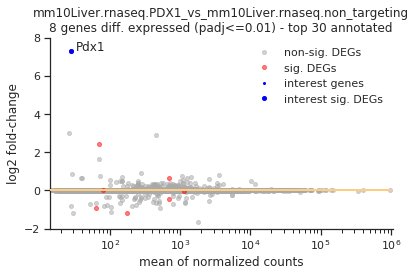

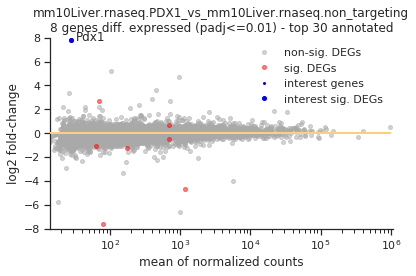

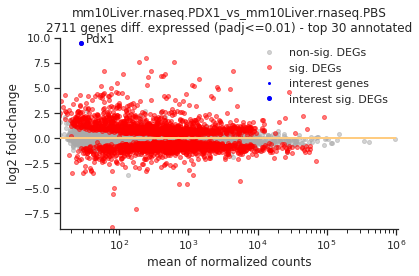

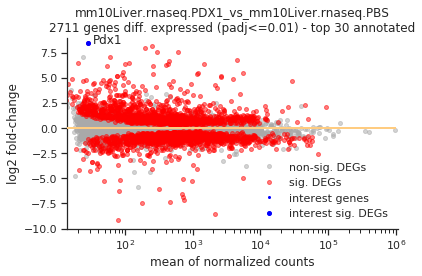

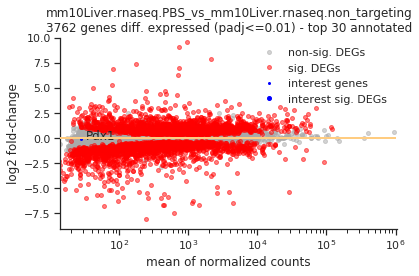

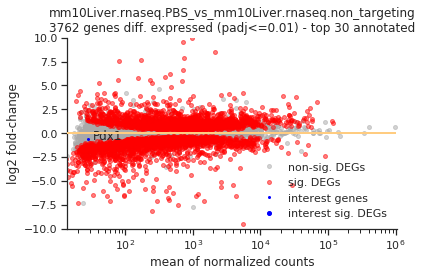

In [8]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30
log2fc_thres = np.log2(2)
special_genes = ["Pdx1"]
comparisons = [
    "mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.non_targeting",
    "mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.PBS",
    "mm10Liver.rnaseq.PBS_vs_mm10Liver.rnaseq.non_targeting"
]

data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing'

for comparison in comparisons:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.with_genes.txt" % (data_dir, comparison, shrinkage),
                        sep="\t")
    #     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
    #                     sep="\t",
    #                     names=['GeneName', 'GeneType'])
    #     df = df.merge(df_gene_name_type, on='GeneName')
    #     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
    #     df = df[~df.GeneType.isin(pseudogene_types)]
    #     df = df[df.GeneType.isin(['protein_coding'])]
#         fig = plt.figure(figsize=(8, 6))
        fig = plt.figure(figsize=(6, 4))
        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 
                'o', color='darkgrey',alpha=0.5, label='non-sig. DEGs', rasterized=True, markersize=4)

        ylims = [np.ceil(df['log2FoldChange'].min()-1), np.floor(df['log2FoldChange'].max()+1)]
        xlims = [np.floor(df.baseMean.min()*1.1), np.ceil(df.baseMean.max()*1.1)]

        df_sig = df[(df.padj<=pval_thres)] #  & (np.abs(df.log2FoldChange)>=log2fc_thres)
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.5, 
                label='sig. DEGs', markersize=4)

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    #     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
    #         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
    #     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

    #     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
    #         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
    #                     textcoords='offset points')

        # Annotate in particular IL1RN, HBG and EP300
        df_annotate_selected = df[df.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='.', linestyle = 'None', alpha=1, label='interest genes', markersize=4)
        for x, y, t in zip(df_annotate_selected['baseMean'].values,
                           df_annotate_selected['log2FoldChange'].values, 
                           df_annotate_selected['GeneName'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                    textcoords='offset points')
        df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs', markersize=4)

        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")
#          & (np.abs(df.log2FoldChange)>=log2fc_thres)
        plt.title("%s\n%d genes diff. expressed (padj<=%.2f) - top %d annotated" % (comparison, 
                                                                                    np.count_nonzero((df.padj<=pval_thres)), 
                                                                                    pval_thres, 
                                                                                    top_to_report))
        plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2,zorder=100)
        plt.legend(frameon=False)

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

    #     # Save annotated MA plot
#         plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.log2fc_gt_1.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))
        plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))

    #     # Save annotated genes without pseudogenes
    #     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
    #                       sep='\t',
    #                       index=False)

        # print table of values 
        print "======", comparison, "======"
        display(df_annotate)

   


====== KS150.CreNeg.g5_vs_KS150.CreNeg.NTC ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType


====== KS150.CreNeg.g5_vs_KS150.CreNeg.NTC ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType


====== KS150.CrePos.g5_vs_KS150.CrePos.NTC ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000039521.12,177.280446,3.409716,0.379638,1.161228e-20,1.380932e-16,Foxp3,protein_coding


====== KS150.CrePos.g5_vs_KS150.CrePos.NTC ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000039521.12,177.280446,3.489987,0.374454,9.320199,1.161228e-20,1.380932e-16,Foxp3,protein_coding


====== KS150.CrePos.g5_vs_KS150.CreNeg.g5 ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000027381.16,1669.673884,-1.675426,0.176602,1.748260e-22,1.379282e-18,Bcl2l11,protein_coding
1,ENSMUSG00000041481.16,420.927408,2.887387,0.303569,2.319681e-22,1.379282e-18,Serpina3g,protein_coding
2,ENSMUSG00000028211.11,2370.007342,-2.212384,0.249849,5.815174e-20,2.305135e-16,Trp53inp1,protein_coding
3,ENSMUSG00000027864.9,1753.260084,1.065830,0.125759,2.125470e-18,6.319022e-15,Ptgfrn,protein_coding
4,ENSMUSG00000027171.10,886.935476,-1.721242,0.208889,8.850692e-18,2.105049e-14,Prrg4,protein_coding
5,ENSMUSG00000024696.8,552.596100,-1.266909,0.153865,1.234613e-17,2.447004e-14,Lpxn,protein_coding
6,ENSMUSG00000023571.4,1649.549973,1.005822,0.122942,2.497674e-17,4.056184e-14,Fam132a,protein_coding
7,ENSMUSG00000071547.3,603.549003,1.609944,0.196145,2.728681e-17,4.056184e-14,Nt5dc2,protein_coding
8,ENSMUSG00000028793.15,5323.554954,0.910940,0.112316,4.281654e-17,5.091743e-14,Rnf19b,protein_coding
9,ENSMUSG00000039521.12,177.280446,4.130024,0.497581,3.950220e-17,5.091743e-14,Foxp3,protein_coding


====== KS150.CrePos.g5_vs_KS150.CreNeg.g5 ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000027381.16,1669.673884,-1.710123,0.175299,-9.755449,1.748260e-22,1.379282e-18,Bcl2l11,protein_coding
1,ENSMUSG00000041481.16,420.927408,2.948122,0.303095,9.726713,2.319681e-22,1.379282e-18,Serpina3g,protein_coding
2,ENSMUSG00000028211.11,2370.007342,-2.263184,0.247404,-9.147713,5.815174e-20,2.305135e-16,Trp53inp1,protein_coding
3,ENSMUSG00000027864.9,1753.260084,1.088073,0.124345,8.750427,2.125470e-18,6.319022e-15,Ptgfrn,protein_coding
4,ENSMUSG00000027171.10,886.935476,-1.769203,0.206009,-8.587986,8.850692e-18,2.105049e-14,Prrg4,protein_coding
5,ENSMUSG00000024696.8,552.596100,-1.300801,0.152147,-8.549651,1.234613e-17,2.447004e-14,Lpxn,protein_coding
6,ENSMUSG00000023571.4,1649.549973,1.031679,0.121833,8.467942,2.497674e-17,4.056184e-14,Fam132a,protein_coding
7,ENSMUSG00000071547.3,603.549003,1.653810,0.195541,8.457629,2.728681e-17,4.056184e-14,Nt5dc2,protein_coding
8,ENSMUSG00000028793.15,5323.554954,0.932466,0.110943,8.404917,4.281654e-17,5.091743e-14,Rnf19b,protein_coding
9,ENSMUSG00000039521.12,177.280446,4.241131,0.504034,8.414367,3.950220e-17,5.091743e-14,Foxp3,protein_coding


====== KS150.CrePos.NTC_vs_KS150.CreNeg.NTC ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000041481.16,420.927408,2.929127,0.268047,3.157454e-29,3.754845e-25,Serpina3g,protein_coding
1,ENSMUSG00000020607.6,1076.502978,1.096627,0.116272,2.337104e-22,1.389642e-18,Fam84a,protein_coding
2,ENSMUSG00000009145.6,366.661009,1.664544,0.183566,5.632466e-21,2.232709e-17,Dqx1,protein_coding
3,ENSMUSG00000033032.15,186.204307,2.047911,0.234818,1.245607e-19,3.703189e-16,Afap1l1,protein_coding
4,ENSMUSG00000035258.14,193.668393,2.650518,0.326605,1.878994e-17,4.468999e-14,Abi3bp,protein_coding
5,ENSMUSG00000094910.1,113.383706,3.561193,0.448563,8.811042e-17,1.746349e-13,D430019H16Rik,protein_coding
6,ENSMUSG00000000440.12,340.939032,1.137662,0.147567,7.097331e-16,1.205735e-12,Pparg,protein_coding
7,ENSMUSG00000061825.10,211.679712,-2.624906,0.341768,1.054519e-15,1.567543e-12,Ces2c,protein_coding
8,ENSMUSG00000009418.15,327.037330,2.836138,0.376462,1.731624e-15,2.288053e-12,Nav1,protein_coding
9,ENSMUSG00000038295.14,2141.439735,-1.447349,0.191474,2.686056e-15,3.194258e-12,Atg9b,protein_coding


====== KS150.CrePos.NTC_vs_KS150.CreNeg.NTC ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000041481.16,420.927408,2.977432,0.265306,11.222628,3.157454e-29,3.754845e-25,Serpina3g,protein_coding
1,ENSMUSG00000020607.6,1076.502978,1.118936,0.115046,9.725951,2.337104e-22,1.389642e-18,Fam84a,protein_coding
2,ENSMUSG00000009145.6,366.661009,1.703130,0.181249,9.396656,5.632466e-21,2.232709e-17,Dqx1,protein_coding
3,ENSMUSG00000033032.15,186.204307,2.099586,0.231614,9.065038,1.245607e-19,3.703189e-16,Afap1l1,protein_coding
4,ENSMUSG00000035258.14,193.668393,2.727326,0.320823,8.501040,1.878994e-17,4.468999e-14,Abi3bp,protein_coding
5,ENSMUSG00000094910.1,113.383706,3.669127,0.441011,8.319802,8.811042e-17,1.746349e-13,D430019H16Rik,protein_coding
6,ENSMUSG00000000440.12,340.939032,1.172715,0.145339,8.068833,7.097331e-16,1.205735e-12,Pparg,protein_coding
7,ENSMUSG00000061825.10,211.679712,-2.711809,0.338116,-8.020341,1.054519e-15,1.567543e-12,Ces2c,protein_coding
8,ENSMUSG00000009418.15,327.037330,2.929919,0.368117,7.959195,1.731624e-15,2.288053e-12,Nav1,protein_coding
9,ENSMUSG00000038295.14,2141.439735,-1.495366,0.189175,-7.904688,2.686056e-15,3.194258e-12,Atg9b,protein_coding


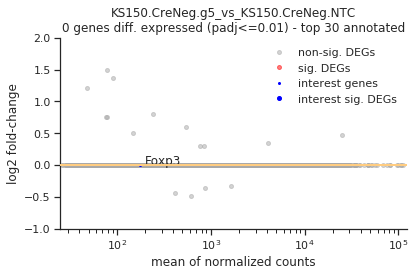

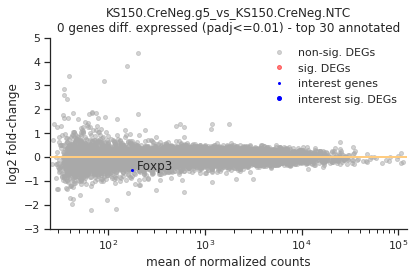

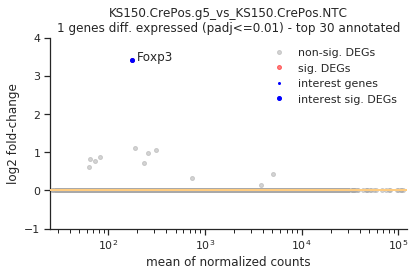

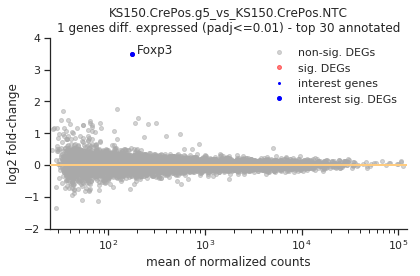

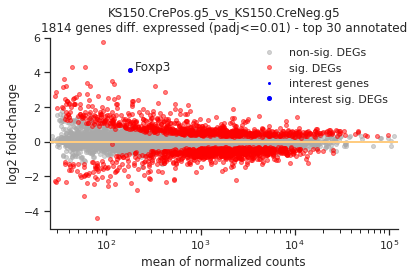

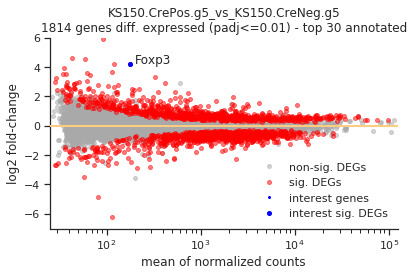

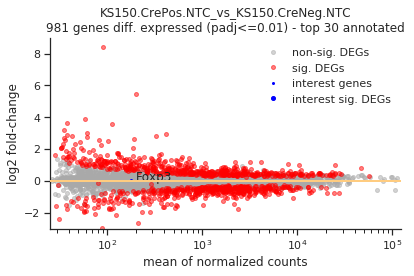

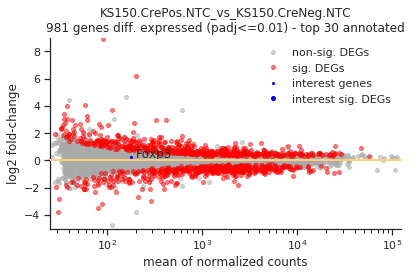

In [9]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30
log2fc_thres = np.log2(2)
special_genes = ["Foxp3"]
comparisons = [
    "KS150.CreNeg.g5_vs_KS150.CreNeg.NTC",
    "KS150.CrePos.g5_vs_KS150.CrePos.NTC",
    "KS150.CrePos.g5_vs_KS150.CreNeg.g5",
    "KS150.CrePos.NTC_vs_KS150.CreNeg.NTC"

]

data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing'

for comparison in comparisons:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.with_genes.txt" % (data_dir, comparison, shrinkage),
                        sep="\t")
    #     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
    #                     sep="\t",
    #                     names=['GeneName', 'GeneType'])
    #     df = df.merge(df_gene_name_type, on='GeneName')
    #     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
    #     df = df[~df.GeneType.isin(pseudogene_types)]
    #     df = df[df.GeneType.isin(['protein_coding'])]

#         fig = plt.figure(figsize=(8, 6))
        fig = plt.figure(figsize=(6, 4))

        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 'o', 
                color='darkgrey',alpha=0.5, label='non-sig. DEGs', rasterized=True, markersize=4)

        ylims = [np.ceil(df['log2FoldChange'].min()-1), np.floor(df['log2FoldChange'].max()+1)]
        xlims = [np.floor(df.baseMean.min()*1.1), np.ceil(df.baseMean.max()*1.1)]

        df_sig = df[(df.padj<=pval_thres)] #  & (np.abs(df.log2FoldChange)>=log2fc_thres)
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.5, 
                label='sig. DEGs', markersize=4)

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    #     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
    #         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
    #     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

    #     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
    #         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
    #                     textcoords='offset points')

        # Annotate in particular IL1RN, HBG and EP300
        df_annotate_selected = df[df.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='.', linestyle = 'None', alpha=1, label='interest genes', markersize=4)
        for x, y, t in zip(df_annotate_selected['baseMean'].values,
                           df_annotate_selected['log2FoldChange'].values, 
                           df_annotate_selected['GeneName'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                    textcoords='offset points')
        df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs', markersize=4)

        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")
#          & (np.abs(df.log2FoldChange)>=log2fc_thres)
        plt.title("%s\n%d genes diff. expressed (padj<=%.2f) - top %d annotated" % (comparison, 
                                                                                    np.count_nonzero((df.padj<=pval_thres)), 
                                                                                    pval_thres, 
                                                                                    top_to_report))
        plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2, zorder=100)
        plt.legend(frameon=False)

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

    #     # Save annotated MA plot
#         plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.log2fc_gt_1.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))
        plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))

    #     # Save annotated genes without pseudogenes
    #     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
    #                       sep='\t',
    #                       index=False)

        # print table of values 
        print "======", comparison, "======"
        display(df_annotate)

   


In [5]:
?plt.hlines

====== KS150.CreNeg.g5_vs_KS150.CreNeg.NTC ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000079017.3,16250.441294,-0.414899,0.095348,2.793878e-07,0.003385,Ifi27l2a,protein_coding


====== KS150.CreNeg.g5_vs_KS150.CreNeg.NTC ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000079017.3,16250.441294,-0.467421,0.090994,-5.136846,2.793878e-07,0.003385,Ifi27l2a,protein_coding


====== KS150.CrePos.g5_vs_KS150.CreNeg.g5 ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000028211.11,2435.487906,-2.027639,0.173822,7.579450e-33,9.182504e-29,Trp53inp1,protein_coding
1,ENSMUSG00000041481.16,388.749018,3.312666,0.283598,5.818611e-32,3.524623e-28,Serpina3g,protein_coding
2,ENSMUSG00000039521.12,166.380346,4.106951,0.366662,7.281029e-30,2.940322e-26,Foxp3,protein_coding
3,ENSMUSG00000027381.16,1761.467655,-1.605777,0.146234,2.824946e-29,8.556056e-26,Bcl2l11,protein_coding
4,ENSMUSG00000015647.9,2124.145459,1.778180,0.166089,6.766037e-28,1.639411e-24,Lama5,protein_coding
5,ENSMUSG00000027171.10,939.326584,-1.665035,0.157135,1.559580e-27,3.149052e-24,Prrg4,protein_coding
6,ENSMUSG00000024424.14,505.805162,1.976771,0.186157,2.080218e-27,3.600264e-24,Ttc39c,protein_coding
7,ENSMUSG00000079017.3,16250.441294,0.864751,0.082044,8.222458e-27,1.245189e-23,Ifi27l2a,protein_coding
8,ENSMUSG00000021127.7,2880.909249,-1.215947,0.117833,3.474285e-26,4.676773e-23,Zfp36l1,protein_coding
9,ENSMUSG00000030671.9,3005.362658,-1.273270,0.124306,4.814538e-26,5.832813e-23,Pde3b,protein_coding


====== KS150.CrePos.g5_vs_KS150.CreNeg.g5 ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000028211.11,2435.487906,-2.059661,0.172542,-11.937129,7.579450e-33,9.182504e-29,Trp53inp1,protein_coding
1,ENSMUSG00000041481.16,388.749018,3.359580,0.285524,11.766353,5.818611e-32,3.524623e-28,Serpina3g,protein_coding
2,ENSMUSG00000039521.12,166.380346,4.169745,0.367326,11.351609,7.281029e-30,2.940322e-26,Foxp3,protein_coding
3,ENSMUSG00000027381.16,1761.467655,-1.630817,0.145188,-11.232462,2.824946e-29,8.556056e-26,Bcl2l11,protein_coding
4,ENSMUSG00000015647.9,2124.145459,1.807167,0.165063,10.948362,6.766037e-28,1.639411e-24,Lama5,protein_coding
5,ENSMUSG00000027171.10,939.326584,-1.693085,0.155723,-10.872449,1.559580e-27,3.149052e-24,Prrg4,protein_coding
6,ENSMUSG00000024424.14,505.805162,2.010069,0.185326,10.846142,2.080218e-27,3.600264e-24,Ttc39c,protein_coding
7,ENSMUSG00000079017.3,16250.441294,0.874620,0.081590,10.719751,8.222458e-27,1.245189e-23,Ifi27l2a,protein_coding
8,ENSMUSG00000021127.7,2880.909249,-1.237549,0.116908,-10.585632,3.474285e-26,4.676773e-23,Zfp36l1,protein_coding
9,ENSMUSG00000030671.9,3005.362658,-1.302072,0.123360,-10.555036,4.814538e-26,5.832813e-23,Pde3b,protein_coding


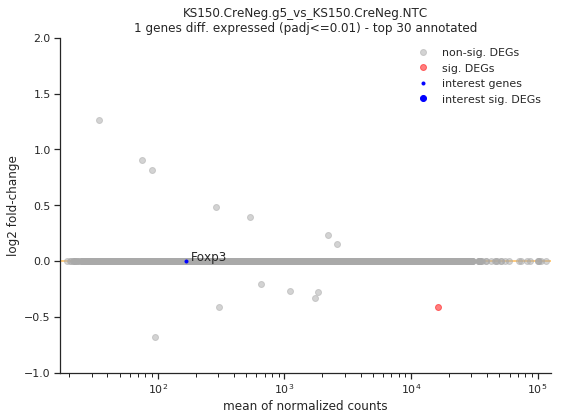

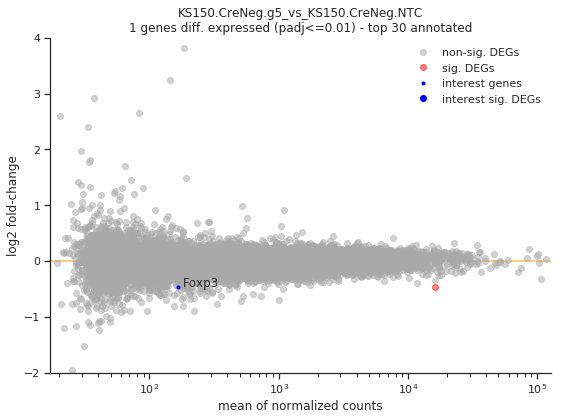

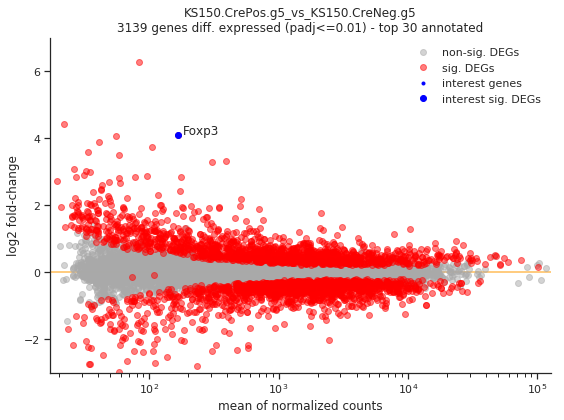

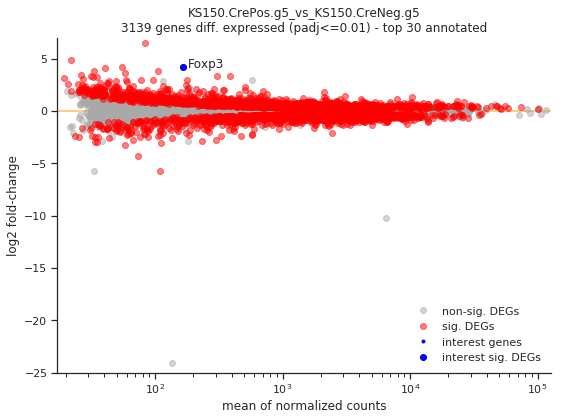

In [8]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30
log2fc_thres = np.log2(2)
special_genes = ["Foxp3"]
comparisons = [
    "KS150.CreNeg.g5_vs_KS150.CreNeg.NTC",
    "KS150.CrePos.g5_vs_KS150.CreNeg.g5",

]

data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/miseq/'

for comparison in comparisons:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.with_genes.txt" % (data_dir, comparison, shrinkage),
                        sep="\t")
    #     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
    #                     sep="\t",
    #                     names=['GeneName', 'GeneType'])
    #     df = df.merge(df_gene_name_type, on='GeneName')
    #     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
    #     df = df[~df.GeneType.isin(pseudogene_types)]
    #     df = df[df.GeneType.isin(['protein_coding'])]
        fig = plt.figure(figsize=(8, 6))
        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 
                'o', color='darkgrey',alpha=0.5, label='non-sig. DEGs')

        ylims = [np.ceil(df['log2FoldChange'].min()-1), np.floor(df['log2FoldChange'].max()+1)]
        xlims = [np.floor(df.baseMean.min()*1.1), np.ceil(df.baseMean.max()*1.1)]

        df_sig = df[(df.padj<=pval_thres)] #  & (np.abs(df.log2FoldChange)>=log2fc_thres)
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.5, label='sig. DEGs')

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    #     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
    #         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
    #     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

    #     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
    #         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
    #                     textcoords='offset points')

        # Annotate in particular IL1RN, HBG and EP300
        df_annotate_selected = df[df.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='.', linestyle = 'None', alpha=1, label='interest genes')
        for x, y, t in zip(df_annotate_selected['baseMean'].values,
                           df_annotate_selected['log2FoldChange'].values, 
                           df_annotate_selected['GeneName'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                    textcoords='offset points')
        df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")
#          & (np.abs(df.log2FoldChange)>=log2fc_thres)
        plt.title("%s\n%d genes diff. expressed (padj<=%.2f) - top %d annotated" % (comparison, 
                                                                                    np.count_nonzero((df.padj<=pval_thres)), 
                                                                                    pval_thres, 
                                                                                    top_to_report))
        plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
        plt.legend(frameon=False)

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

    #     # Save annotated MA plot
#         plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.log2fc_gt_1.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))
        plt.savefig("%s/degs.%s%s.with_genes.annotated_plot_MA.pdf" % (data_dir, comparison, shrinkage))

    #     # Save annotated genes without pseudogenes
    #     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
    #                       sep='\t',
    #                       index=False)

        # print table of values 
        print "======", comparison, "======"
        display(df_annotate)

   


====== KS150.CreNeg.g5_vs_KS150.CreNeg.NTC ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000027236.8,787.255858,1.605288,0.307739,6.130290e-09,0.000059,Eif3j1,protein_coding


====== KS150.CreNeg.g5_vs_KS150.CreNeg.NTC ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000027236.8,787.255858,1.713232,0.294716,5.813164,6.130290e-09,0.000074,Eif3j1,protein_coding


====== KS150.CrePos.g5_vs_KS150.CreNeg.g5 ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000041481.16,432.665025,3.092713,0.256568,1.851397e-34,2.245004e-30,Serpina3g,protein_coding
1,ENSMUSG00000028211.11,2733.751817,-2.088049,0.192927,1.455036e-28,8.821881e-25,Trp53inp1,protein_coding
2,ENSMUSG00000033032.15,192.607750,2.344598,0.217912,5.085542e-28,2.055576e-24,Afap1l1,protein_coding
3,ENSMUSG00000039521.12,182.911222,4.190234,0.397024,5.311782e-27,1.610267e-23,Foxp3,protein_coding
4,ENSMUSG00000009418.15,332.165401,3.551586,0.342218,1.950714e-26,4.730873e-23,Nav1,protein_coding
5,ENSMUSG00000027171.10,1051.178492,-1.716339,0.168147,1.022641e-25,2.066758e-22,Prrg4,protein_coding
6,ENSMUSG00000024696.8,640.166539,-1.258838,0.124610,3.196149e-25,5.536644e-22,Lpxn,protein_coding
7,ENSMUSG00000027329.9,255.672880,2.001240,0.197717,4.291767e-25,6.505246e-22,Spef1,protein_coding
8,ENSMUSG00000024424.14,565.394984,1.813610,0.181699,1.055816e-24,1.422536e-21,Ttc39c,protein_coding
9,ENSMUSG00000023571.4,1771.295917,0.996040,0.099796,2.250392e-24,2.480750e-21,Fam132a,protein_coding


====== KS150.CrePos.g5_vs_KS150.CreNeg.g5 ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000041481.16,432.665025,3.131353,0.255785,12.242117,1.851397e-34,2.245004e-30,Serpina3g,protein_coding
1,ENSMUSG00000028211.11,2733.751817,-2.121909,0.191392,-11.086734,1.455036e-28,8.821881e-25,Trp53inp1,protein_coding
2,ENSMUSG00000033032.15,192.607750,2.383201,0.217164,10.974197,5.085542e-28,2.055576e-24,Afap1l1,protein_coding
3,ENSMUSG00000039521.12,182.911222,4.263198,0.396205,10.760091,5.311782e-27,1.610267e-23,Foxp3,protein_coding
4,ENSMUSG00000009418.15,332.165401,3.615644,0.339831,10.639549,1.950714e-26,4.730873e-23,Nav1,protein_coding
5,ENSMUSG00000027171.10,1051.178492,-1.746908,0.166625,-10.484054,1.022641e-25,2.066758e-22,Prrg4,protein_coding
6,ENSMUSG00000024696.8,640.166539,-1.283553,0.123707,-10.375773,3.196149e-25,5.536644e-22,Lpxn,protein_coding
7,ENSMUSG00000027329.9,255.672880,2.037751,0.196930,10.347585,4.291767e-25,6.505246e-22,Spef1,protein_coding
8,ENSMUSG00000024424.14,565.394984,1.848117,0.180110,10.261024,1.055816e-24,1.422536e-21,Ttc39c,protein_coding
9,ENSMUSG00000023571.4,1771.295917,1.010974,0.099235,10.187694,2.250392e-24,2.480750e-21,Fam132a,protein_coding


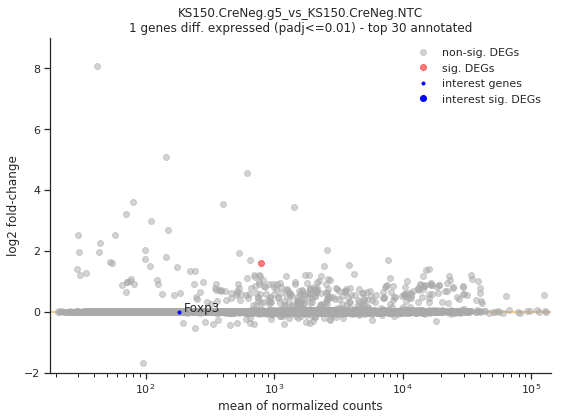

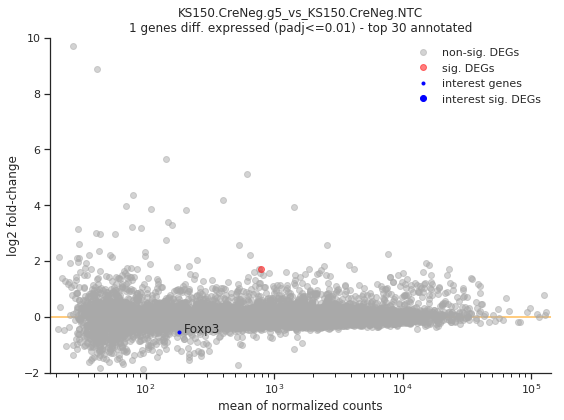

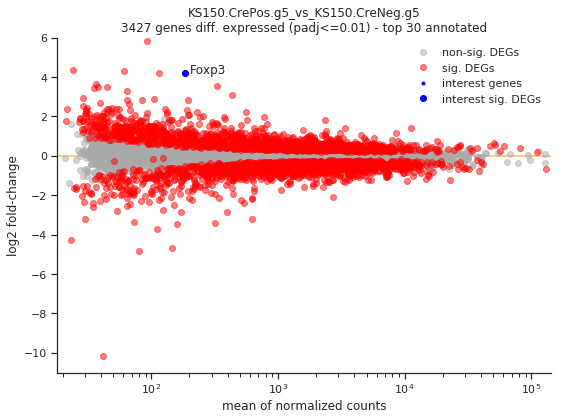

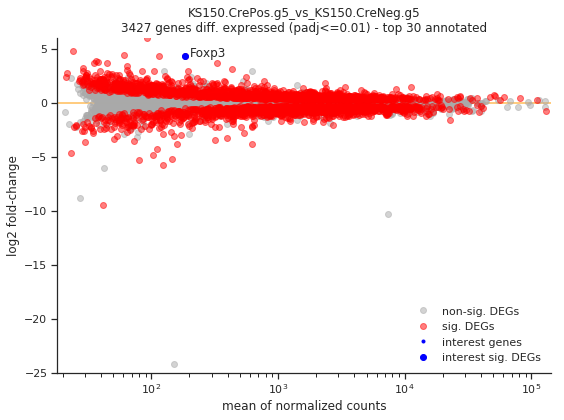

In [2]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30
log2fc_thres = np.log2(2)
special_genes = ["Foxp3"]
comparisons = [
    "KS150.CreNeg.g5_vs_KS150.CreNeg.NTC",
    "KS150.CrePos.g5_vs_KS150.CreNeg.g5",

]

data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/redo/nextseq/'

for comparison in comparisons:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.with_genes.txt" % (data_dir, comparison, shrinkage),
                        sep="\t")
    #     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
    #                     sep="\t",
    #                     names=['GeneName', 'GeneType'])
    #     df = df.merge(df_gene_name_type, on='GeneName')
    #     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
    #     df = df[~df.GeneType.isin(pseudogene_types)]
    #     df = df[df.GeneType.isin(['protein_coding'])]
        fig = plt.figure(figsize=(8, 6))
        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 
                'o', color='darkgrey',alpha=0.5, label='non-sig. DEGs')

        ylims = [np.ceil(df['log2FoldChange'].min()-1), np.floor(df['log2FoldChange'].max()+1)]
        xlims = [np.floor(df.baseMean.min()*1.1), np.ceil(df.baseMean.max()*1.1)]

        df_sig = df[(df.padj<=pval_thres)] #  & (np.abs(df.log2FoldChange)>=log2fc_thres)
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.5, label='sig. DEGs')

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    #     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
    #         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
    #     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

    #     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
    #         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
    #                     textcoords='offset points')

        # Annotate in particular IL1RN, HBG and EP300
        df_annotate_selected = df[df.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='.', linestyle = 'None', alpha=1, label='interest genes')
        for x, y, t in zip(df_annotate_selected['baseMean'].values,
                           df_annotate_selected['log2FoldChange'].values, 
                           df_annotate_selected['GeneName'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                    textcoords='offset points')
        df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")
#          & (np.abs(df.log2FoldChange)>=log2fc_thres)
        plt.title("%s\n%d genes diff. expressed (padj<=%.2f) - top %d annotated" % (comparison, 
                                                                                    np.count_nonzero((df.padj<=pval_thres)), 
                                                                                    pval_thres, 
                                                                                    top_to_report))
        plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
        plt.legend(frameon=False)

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

    #     # Save annotated MA plot
#         plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.log2fc_gt_1.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))
        plt.savefig("%s/degs.%s%s.with_genes.annotated_plot_MA.pdf" % (data_dir, comparison, shrinkage))

    #     # Save annotated genes without pseudogenes
    #     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
    #                       sep='\t',
    #                       index=False)

        # print table of values 
        print "======", comparison, "======"
        display(df_annotate)

   


====== mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.non_targeting ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
1,ENSMUSG00000029644.7,28.197758,7.315295,1.301479,1.579325e-09,0.000010,Pdx1,protein_coding
3,ENSMUSG00000081223.1,70.514393,2.452746,0.543561,2.486963e-07,0.000636,Gm12247,processed_pseudogene
5,ENSMUSG00000079017.3,174.433347,-1.181461,0.264187,3.159425e-07,0.000673,Ifi27l2a,protein_coding


====== mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.non_targeting ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
1,ENSMUSG00000029644.7,28.197758,7.789290,1.290461,6.036050,1.579325e-09,0.000010,Pdx1,protein_coding
3,ENSMUSG00000081223.1,70.514393,2.672135,0.517988,5.158680,2.486963e-07,0.000636,Gm12247,processed_pseudogene
4,ENSMUSG00000105703.1,1154.865099,-4.685246,0.905339,-5.175127,2.277559e-07,0.000636,Gm43305,TEC
5,ENSMUSG00000079017.3,174.433347,-1.289426,0.252152,-5.113680,3.159425e-07,0.000673,Ifi27l2a,protein_coding
6,ENSMUSG00000052435.6,78.923657,-7.663483,1.535772,-4.989987,6.038330e-07,0.001103,Cebpe,protein_coding
7,ENSMUSG00000035208.16,63.349776,-1.059521,0.233946,-4.528919,5.928615e-06,0.009473,Slfn8,protein_coding


====== mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.PBS ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000032715.9,2125.659541,4.242446,0.207720,8.996589e-94,1.150034e-89,Trib3,protein_coding
1,ENSMUSG00000025408.15,2297.162239,3.947221,0.232505,8.326167e-66,5.321670e-62,Ddit3,protein_coding
2,ENSMUSG00000029378.5,611.776762,7.545164,0.446660,7.588371e-64,3.233405e-60,Areg,protein_coding
3,ENSMUSG00000030717.9,4432.701734,6.702499,0.449412,1.942474e-51,6.207662e-48,Nupr1,protein_coding
4,ENSMUSG00000026456.18,1276.260476,3.182413,0.223179,3.353484e-47,8.573518e-44,Cyb5r1,protein_coding
5,ENSMUSG00000022474.14,937.160081,4.348909,0.306785,4.327342e-47,9.219402e-44,Pmm1,protein_coding
6,ENSMUSG00000023905.14,1014.161712,3.274493,0.271718,1.292020e-34,2.359412e-31,Tnfrsf12a,protein_coding
7,ENSMUSG00000004038.9,28909.115310,4.602004,0.385532,4.104951e-34,6.559198e-31,Gstm3,protein_coding
8,ENSMUSG00000038539.15,11968.378376,1.772509,0.152673,3.015630e-32,4.283200e-29,Atf5,protein_coding
9,ENSMUSG00000047904.6,408.121151,6.163472,0.540358,8.929408e-32,1.141446e-28,Sstr2,protein_coding


====== mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.PBS ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000032715.9,2125.659541,4.262107,0.207478,20.542420,8.996589e-94,1.150034e-89,Trib3,protein_coding
1,ENSMUSG00000025408.15,2297.162239,3.974305,0.231959,17.133651,8.326167e-66,5.321670e-62,Ddit3,protein_coding
2,ENSMUSG00000029378.5,611.776762,7.598457,0.450435,16.869147,7.588371e-64,3.233405e-60,Areg,protein_coding
3,ENSMUSG00000030717.9,4432.701734,6.761877,0.448163,15.087998,1.942474e-51,6.207662e-48,Nupr1,protein_coding
4,ENSMUSG00000026456.18,1276.260476,3.212174,0.222605,14.429945,3.353484e-47,8.573518e-44,Cyb5r1,protein_coding
5,ENSMUSG00000022474.14,937.160081,4.390634,0.304644,14.412350,4.327342e-47,9.219402e-44,Pmm1,protein_coding
6,ENSMUSG00000023905.14,1014.161712,3.317306,0.270331,12.271275,1.292020e-34,2.359412e-31,Tnfrsf12a,protein_coding
7,ENSMUSG00000004038.9,28909.115310,4.663896,0.382998,12.177331,4.104951e-34,6.559198e-31,Gstm3,protein_coding
8,ENSMUSG00000038539.15,11968.378376,1.795381,0.151872,11.821688,3.015630e-32,4.283200e-29,Atf5,protein_coding
9,ENSMUSG00000047904.6,408.121151,6.257345,0.533441,11.730156,8.929408e-32,1.141446e-28,Sstr2,protein_coding


====== mm10Liver.rnaseq.PBS_vs_mm10Liver.rnaseq.non_targeting ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000032715.9,2125.659541,-3.726936,0.207507,5.942828e-73,7.596717e-69,Trib3,protein_coding
1,ENSMUSG00000029378.5,611.776762,-7.492818,0.446777,5.133557e-63,3.281113e-59,Areg,protein_coding
2,ENSMUSG00000025408.15,2297.162239,-3.565882,0.232640,3.407757e-54,1.452045e-50,Ddit3,protein_coding
3,ENSMUSG00000030717.9,4432.701734,-6.509920,0.449355,1.045004e-48,3.339573e-45,Nupr1,protein_coding
4,ENSMUSG00000022474.14,937.160081,-4.308774,0.306609,2.470025e-46,6.314866e-43,Pmm1,protein_coding
5,ENSMUSG00000004038.9,28909.115310,-5.377740,0.384696,1.085914e-45,2.313540e-42,Gstm3,protein_coding
6,ENSMUSG00000026456.18,1276.260476,-3.037977,0.223096,2.548338e-43,4.653629e-40,Cyb5r1,protein_coding
7,ENSMUSG00000058135.12,91786.748899,-2.394146,0.189401,9.557227e-38,1.527125e-34,Gstm1,protein_coding
8,ENSMUSG00000039745.8,2534.120013,-2.353933,0.190623,3.704921e-36,5.262223e-33,Htatip2,protein_coding
9,ENSMUSG00000025351.14,3936.314902,-5.376653,0.440894,1.792096e-35,2.290837e-32,Cd63,protein_coding


====== mm10Liver.rnaseq.PBS_vs_mm10Liver.rnaseq.non_targeting ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000032715.9,2125.659541,-3.748610,0.207499,-18.065640,5.942828e-73,7.596717e-69,Trib3,protein_coding
1,ENSMUSG00000029378.5,611.776762,-7.544998,0.450291,-16.755834,5.133557e-63,3.281113e-59,Areg,protein_coding
2,ENSMUSG00000025408.15,2297.162239,-3.595468,0.231949,-15.501143,3.407757e-54,1.452045e-50,Ddit3,protein_coding
3,ENSMUSG00000030717.9,4432.701734,-6.573123,0.448150,-14.667246,1.045004e-48,3.339573e-45,Nupr1,protein_coding
4,ENSMUSG00000022474.14,937.160081,-4.351718,0.304496,-14.291563,2.470025e-46,6.314866e-43,Pmm1,protein_coding
5,ENSMUSG00000004038.9,28909.115310,-5.433833,0.382986,-14.188080,1.085914e-45,2.313540e-42,Gstm3,protein_coding
6,ENSMUSG00000026456.18,1276.260476,-3.070386,0.222492,-13.800005,2.548338e-43,4.653629e-40,Cyb5r1,protein_coding
7,ENSMUSG00000058135.12,91786.748899,-2.432057,0.189385,-12.841843,9.557227e-38,1.527125e-34,Gstm1,protein_coding
8,ENSMUSG00000039745.8,2534.120013,-2.382017,0.189718,-12.555572,3.704921e-36,5.262223e-33,Htatip2,protein_coding
9,ENSMUSG00000025351.14,3936.314902,-5.449651,0.438421,-12.430189,1.792096e-35,2.290837e-32,Cd63,protein_coding


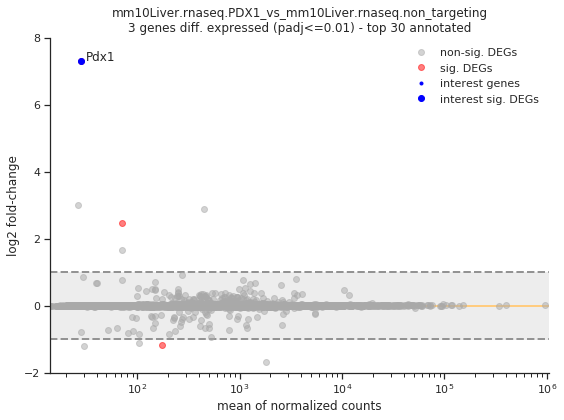

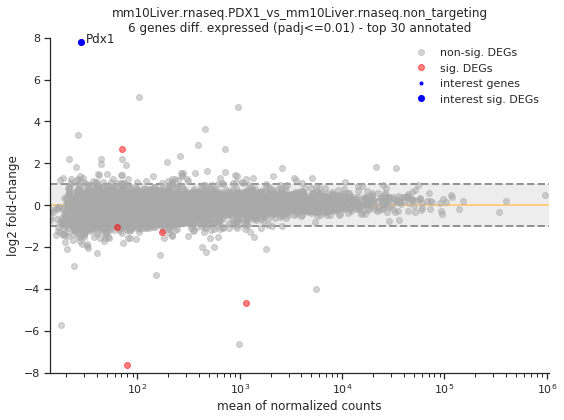

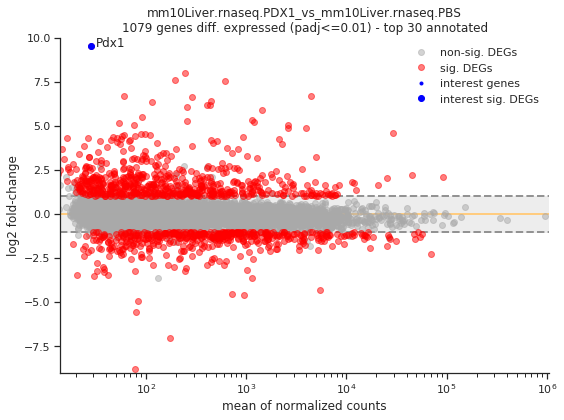

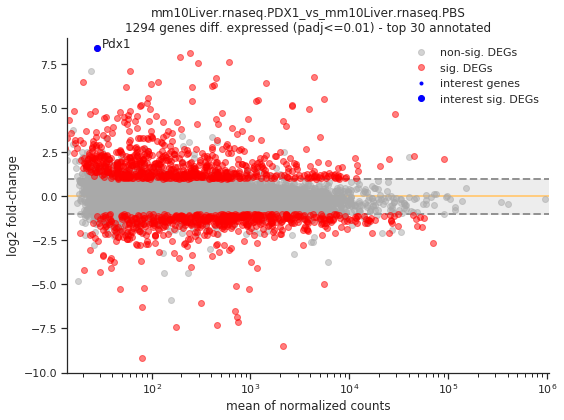

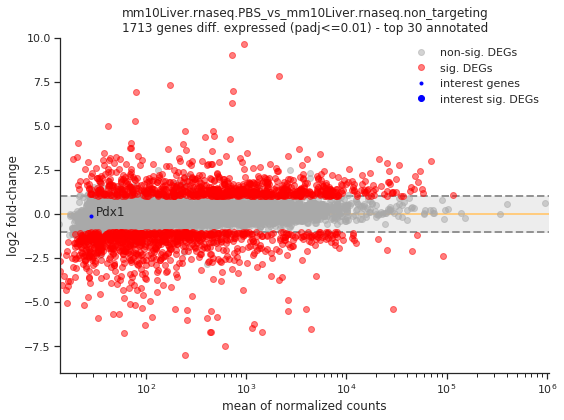

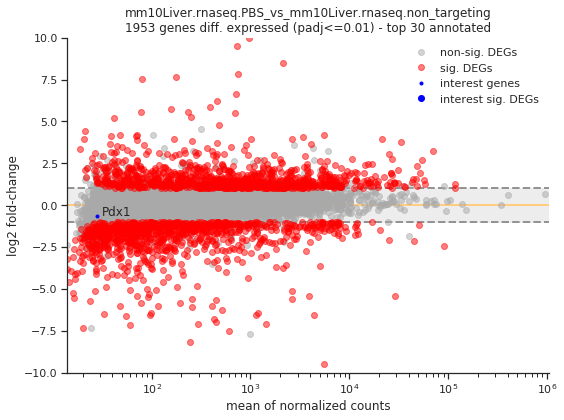

In [2]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib import patches
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30
log2fc_thres = np.log2(2)
special_genes = ["Pdx1", "Plut"]
comparisons = [
    "mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.non_targeting",
    "mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.PBS",
    "mm10Liver.rnaseq.PBS_vs_mm10Liver.rnaseq.non_targeting"
]

data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing'

for comparison in comparisons:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.with_genes.txt" % (data_dir, comparison, shrinkage),
                        sep="\t")
    #     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
    #                     sep="\t",
    #                     names=['GeneName', 'GeneType'])
    #     df = df.merge(df_gene_name_type, on='GeneName')
    #     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
    #     df = df[~df.GeneType.isin(pseudogene_types)]
    #     df = df[df.GeneType.isin(['protein_coding'])]
        fig = plt.figure(figsize=(8, 6))
        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 
                'o', color='darkgrey',alpha=0.5, label='non-sig. DEGs')

        ylims = [np.ceil(df['log2FoldChange'].min()-1), np.floor(df['log2FoldChange'].max()+1)]
        xlims = [np.floor(df.baseMean.min()*1.1), np.ceil(df.baseMean.max()*1.1)]

        df_sig = df[(df.padj<=pval_thres) & (np.abs(df.log2FoldChange)>=log2fc_thres)]
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.5, label='sig. DEGs')

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    #     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
    #         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
    #     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

    #     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
    #         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
    #                     textcoords='offset points')

        # Annotate in particular IL1RN, HBG and EP300
        df_annotate_selected = df[df.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='.', linestyle = 'None', alpha=1, label='interest genes')
        for x, y, t in zip(df_annotate_selected['baseMean'].values,
                           df_annotate_selected['log2FoldChange'].values, 
                           df_annotate_selected['GeneName'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                    textcoords='offset points')
        df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

        plt.xlim(xlims)
        plt.ylim(ylims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")
#          & (np.abs(df.log2FoldChange)>=log2fc_thres)
        plt.title("%s\n%d genes diff. expressed (padj<=%.2f) - top %d annotated" % (comparison, 
                                                                                    np.count_nonzero((df.padj<=pval_thres) & (np.abs(df.log2FoldChange)>=log2fc_thres)), 
                                                                                    pval_thres, 
                                                                                    top_to_report))
        ax.add_patch(patches.Rectangle((0, -log2fc_thres), xlims[1], 2*log2fc_thres, fill=True, color='#ededed'))
        plt.hlines(0, xlims[0], xlims[1], color='#ffcc80', linewidth =2 )
        plt.hlines(-log2fc_thres, xlims[0], xlims[1], color='#939393', linewidth =2, linestyle= '--' )
        plt.hlines(log2fc_thres, xlims[0], xlims[1], color='#939393', linewidth =2, linestyle= '--' )
        plt.legend(frameon=False)

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

    #     # Save annotated MA plot
#         plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.log2fc_gt_1.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))
#         plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))

    #     # Save annotated genes without pseudogenes
    #     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
    #                       sep='\t',
    #                       index=False)

        # print table of values 
        print "======", comparison, "======"
        display(df_annotate)

   


In [6]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
export PYTHONPATH="/data/reddylab/projects/GGR/analyses/group_general/top_level_scripts/GGR:${PYTHONPATH}"
INPUTDIR=/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing
OUTDIR=${INPUTDIR}
cd ${INPUTDIR}
FDR=0.05
for FDR in 0.001;# 0.01 0.05 0.10 0.20;
do
    python /data/reddylab/Alex/reddylab_utils/scripts/plot_overlap_as_venn_diagram.py \
        -i \
            <(tail -n+2 mm10Liver.rnaseq.PBS_vs_mm10Liver.rnaseq.non_targeting.unshrunk.txt | awk -vFDR=${FDR} '$NF<FDR{print $1}') \
            <(tail -n+2 mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.PBS.unshrunk.txt | awk -vFDR=${FDR} '$NF<FDR{print $1}') \
        --names nontargeting_vs_PBS PDX1_vs_PBS \
        --title "DE genes breakdown - FDR<=${FDR}" \
        --save-subsets \
        -o \
            ${OUTDIR}/nontargeting_vs_PBS.PDX1_vs_PBS.FDR_${FDR}.peaks_venn.png \
            ${OUTDIR}/nontargeting_vs_PBS.PDX1_vs_PBS.FDR_${FDR}.peaks_venn.pdf
done

In [7]:
from IPython.display import Image, display

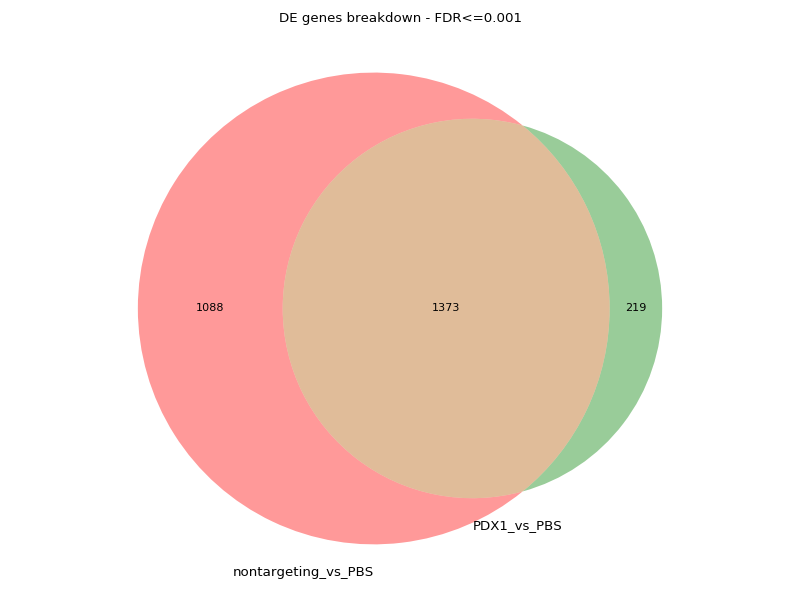

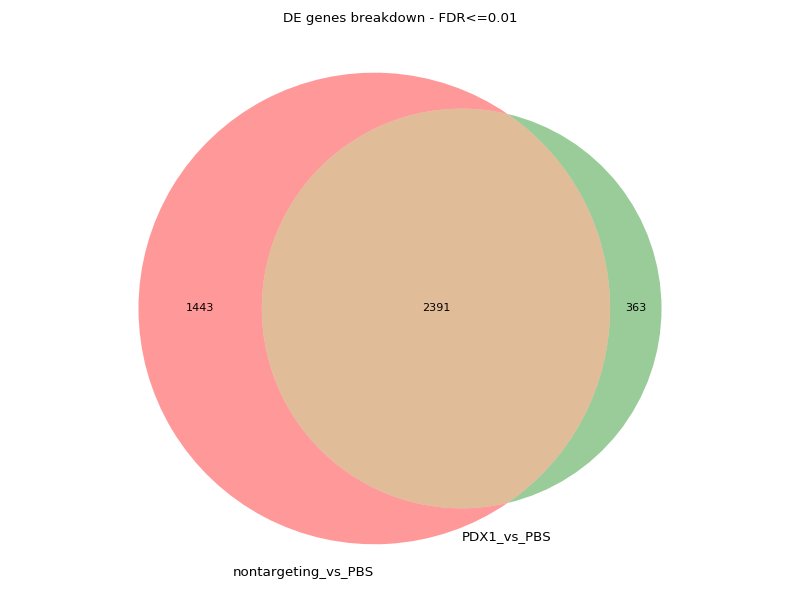

In [10]:
from IPython.display import Image, display
data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing'
for fdr in ["0.001", "0.01"]:#, "0.05", "0.10", "0.20"]:
    display(Image('%s/nontargeting_vs_PBS.PDX1_vs_PBS.FDR_%s.peaks_venn.png' % (data_dir, fdr)))